In [1]:
from oceanoi import cov, oisparse, oidask, oi
import numpy as np
import matplotlib.pyplot as plt
from dask import array as da

In [2]:
%matplotlib notebook

In [3]:
def spectral_mixture_kernel(x, xpr, params):
    eta, l, T = params
    #T = 2*np.sqrt(T)
    
    return eta**2 *cov.expquad(x[:,0,None], xpr[:,0,None].T, l)*\
        cov.cosine(x[:,0,None], xpr[:,0,None].T, T)

def spectral_mixture_kernel_old(x, xpr, params):
    eta, l, T = params    
    return eta**2 *cov.expquad(x, xpr, l)*\
        cov.cosine(x, xpr, T)

#2D Kernel
def spectral_mixture_kernel_2d(X1, X2, params):
    
    assert X1.shape[1] == 2
    
    eta, decay_x, l_x, decay_y, l_y =  params
    l_x = np.sqrt(l_x)
    l_y = np.sqrt(l_y)
    
    #print(X1.shape)
    #print(cov.expquad(X1[:,0,None], X2[:,0,None].T, decay_x).shape)
    return eta**2 *cov.expquad(X1[:,0,None], X2[:,0,None].T, decay_x)*\
        cov.cosine(X1[:,0,None], X2[:,0,None].T, l_x) *\
        cov.expquad(X1[:,1,None], X2[:,1,None].T, decay_y)*\
        cov.cosine(X1[:,1,None], X2[:,1,None].T, l_y)

def matern_2d(X1, X2, params):
    
    assert X1.shape[1] == 2
    
    eta, nu, l_x, l_y =  params
    
    dx = np.sqrt(np.power(X1[:,0,None]-X2[:,0,None].T,2))
    dy = np.sqrt(np.power(X1[:,1,None]-X2[:,1,None].T,2))

    return eta**2 * cov.matern_general(dx, 1, nu, l_x) *\
        cov.matern_general(dy, 1, nu, l_y)

N = 8760, M = 8760
----
	Kdd = 16542584 (132.340672 MB)
	Kmd = 16542584 (132.340672 MB)
	w_md [8760, 8760] = 1 (8e-06 MB)
Potential memory: 613.9008 MB


<IPython.core.display.Javascript object>


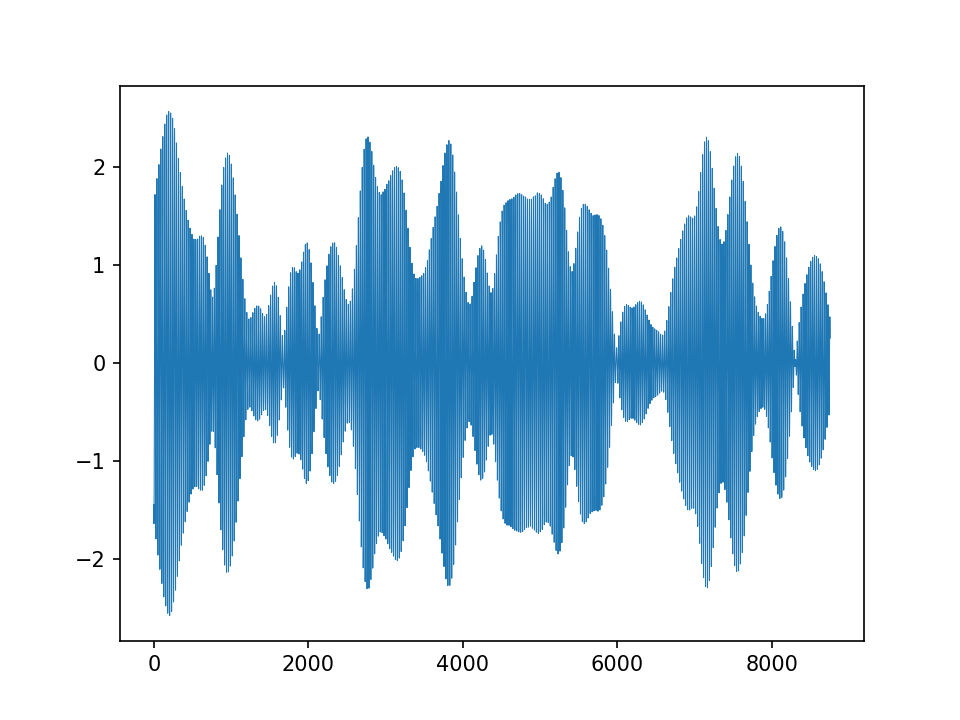

CPU times: user 17.7 s, sys: 1.18 s, total: 18.9 s
Wall time: 6.63 s


In [4]:
%%time

#########
# Parameters
noise = 0.1
covfunc = spectral_mixture_kernel
covparams = (1.0, 7*24, np.sqrt(12.42))
dx = 1.0
N = 365*24

#########


xd = np.arange(0,dx*N,dx)
xo = xd # np.linspace(-10*dx,dx*N+dx*10,N*2)
OIs = oisparse.OptimalInterpSparse(xd[:,None], xo[:,None], noise, covfunc, covparams, chunksize=1000, threshold=1e-8)

yd = OIs.sample_prior(1)
yo = OIs(yd)


OIs.print_matrix_sizes()
print('Potential memory: {} MB'.format(OIs.N**2*8*1e-6))

plt.figure()
plt.plot(xo, yo, lw=0.5)

<IPython.core.display.Javascript object>


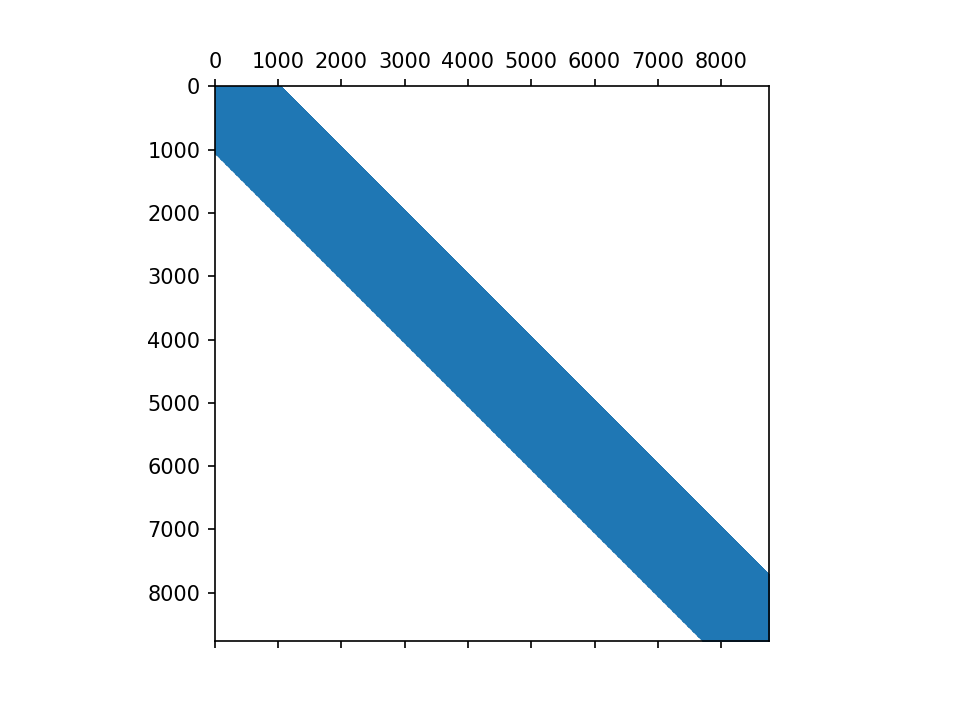

In [5]:
plt.figure()
plt.spy(OIs.Kdd, ms=0.1)

<IPython.core.display.Javascript object>


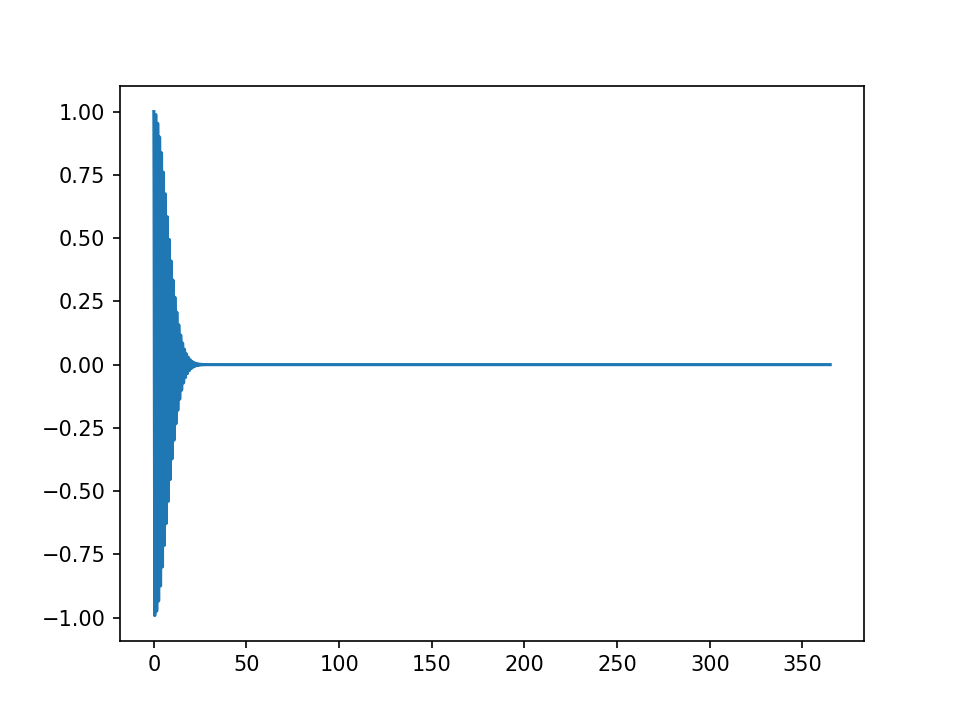

In [6]:
plt.figure()
plt.plot(xd/24, OIs.Kdd[0,:].toarray()[0,...])

(7200, 2)
N = 7200, M = 7200
----
	Kdd = 41187036 (329.496288 MB)
	Kmd = 41187036 (329.496288 MB)
	w_md [7200, 7200] = 1 (8e-06 MB)
Potential memory: 414.71999999999997 MB


<IPython.core.display.Javascript object>


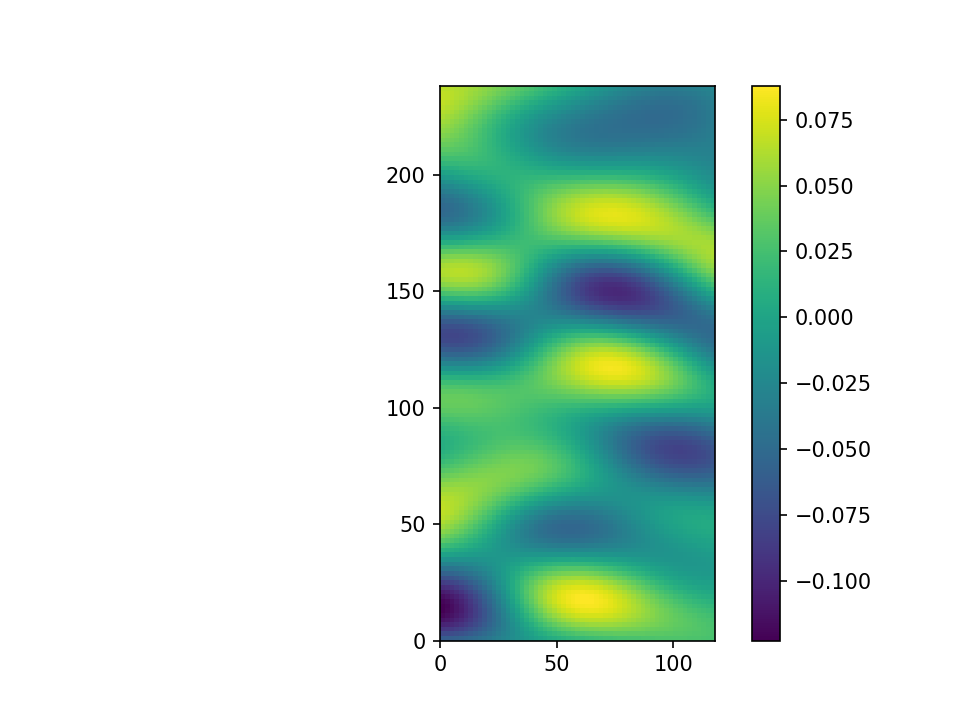

CPU times: user 52.3 s, sys: 2.76 s, total: 55.1 s
Wall time: 45.8 s


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [14]:
%%time

#########
# Parameters
noise = 0.1
covfunc = spectral_mixture_kernel_2d
covparams = (0.05, 50, 100., 30., 40.1)
dx = 4.0
nx = 30
ny = 60


dx = 2.0
nx = 60
ny = 120
#########
xin, yin = np.arange(0,dx*nx,dx) , np.arange(0,dx*ny,dx)
xd, yd = np.meshgrid(xin, yin)
xo = xd # np.linspace(-10*dx,dx*N+dx*10,N*2)
yo = yd

Xd = np.array([xd.ravel(),yd[:,None].ravel()]).T
Xo = np.array([xo[:,None].ravel(),yo[:,None].ravel()]).T

print(Xd.shape)

OIs = oisparse.OptimalInterpSparse(Xd, Xo, noise, covfunc, covparams, chunksize=1000, threshold=1e-8)

yd = OIs.sample_prior(1)
yo = OIs(yd)


OIs.print_matrix_sizes()
print('Potential memory: {} MB'.format(OIs.N**2*8*1e-6))

plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, yo.reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

# plt.figure()
# plt.spy(OIs.Kdd, ms=0.1)

<IPython.core.display.Javascript object>


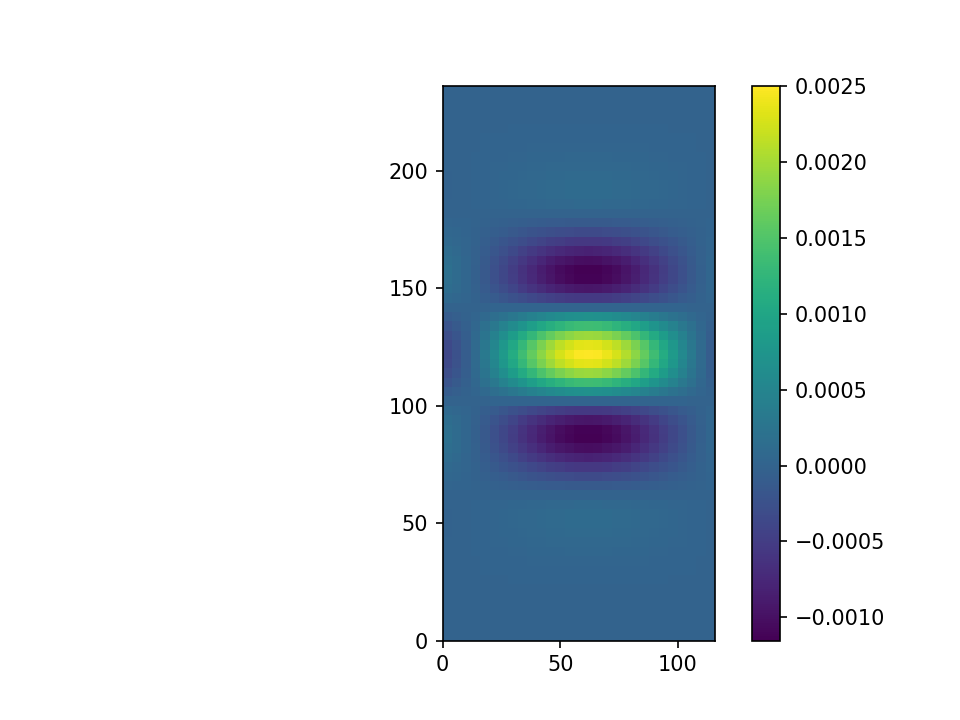

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, OIs.Kdd[nx*ny//2+nx//2,:].toarray().reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

(1800, 2)


/home/jupyter-ubuntu/code/oceanoi/oceanoi/cov.py:73: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu,cff1)


N = 1800, M = 1800
----
	Kdd = 2907264 (23.258112 MB)
	Kmd = 2907264 (23.258112 MB)
	w_md [1800, 1800] = 1 (8e-06 MB)
Potential memory: 25.919999999999998 MB


<IPython.core.display.Javascript object>


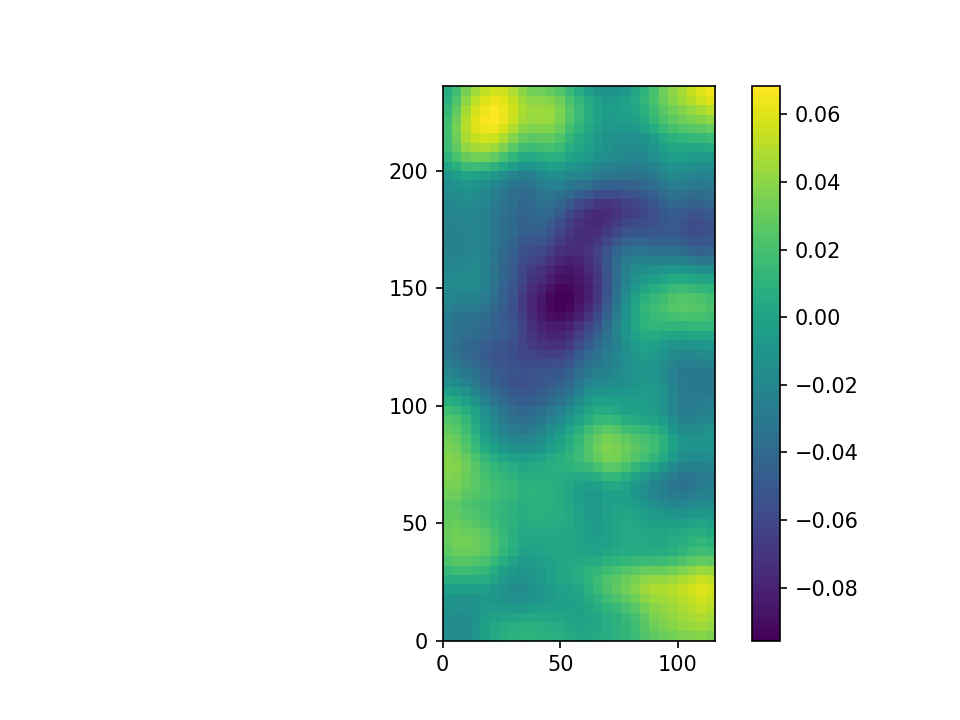

CPU times: user 6.55 s, sys: 115 ms, total: 6.66 s
Wall time: 2.66 s


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [9]:
%%time

#########
# Parameters
noise = 0.1
covfunc = matern_2d
nu=1.0
covparams = (0.05, nu, 20., 20.)
dx = 4.0
nx = 30
ny = 60

# dx = 2.0
# nx = 60
# ny = 120
#########
xin, yin = np.arange(0,dx*nx,dx) , np.arange(0,dx*ny,dx)
xd, yd = np.meshgrid(xin, yin)
xo = xd # np.linspace(-10*dx,dx*N+dx*10,N*2)
yo = yd

Xd = np.array([xd.ravel(),yd[:,None].ravel()]).T
Xo = np.array([xo[:,None].ravel(),yo[:,None].ravel()]).T

print(Xd.shape)

OIs = oisparse.OptimalInterpSparse(Xd, Xo, noise, covfunc, covparams, chunksize=1000, threshold=1e-8)

yd = OIs.sample_prior(1)
yo = OIs(yd)


OIs.print_matrix_sizes()
print('Potential memory: {} MB'.format(OIs.N**2*8*1e-6))

plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, yo.reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

# plt.figure()
# plt.spy(OIs.Kdd, ms=0.1)

<IPython.core.display.Javascript object>


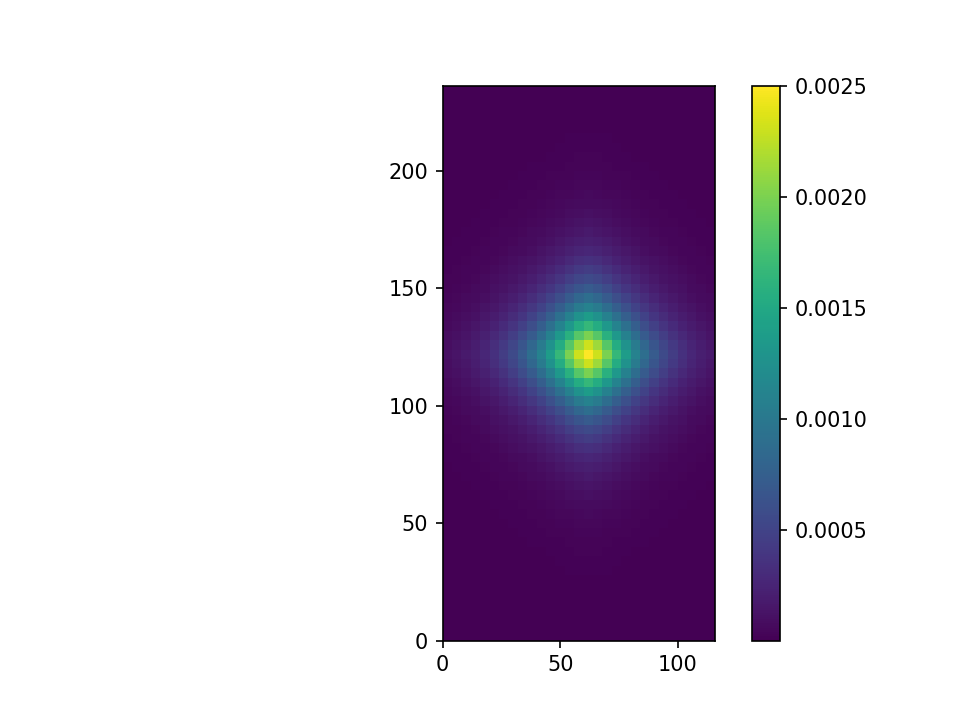

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, OIs.Kdd[nx*ny//2+nx//2,:].toarray().reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

In [15]:
%%time

#########
# Parameters
noise = 0.1
covfunc = spectral_mixture_kernel_2d
covparams = (0.05, 120, 100., 60., 40.1)
dx = 2.0
nx = 60
ny = 120
#########
xin, yin = np.arange(0,dx*nx,dx) , np.arange(0,dx*ny,dx)
xd, yd = np.meshgrid(xin, yin)
xo = xd # np.linspace(-10*dx,dx*N+dx*10,N*2)
yo = yd

Xd = np.array([xd.ravel(),yd[:,None].ravel()]).T
Xo = np.array([xo[:,None].ravel(),yo[:,None].ravel()]).T

print(Xd.shape)

OIs = oidask.OptimalInterpDask(Xd, Xo, noise, covfunc, covparams, chunksize=2000, threshold=1e-8)

yd = OIs.sample_prior(1).compute()
yo = OIs(yd)


plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, yo.reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

# plt.figure()
# plt.spy(OIs.Kdd, ms=0.1)

(7200, 2)


AssertionError: 

<IPython.core.display.Javascript object>


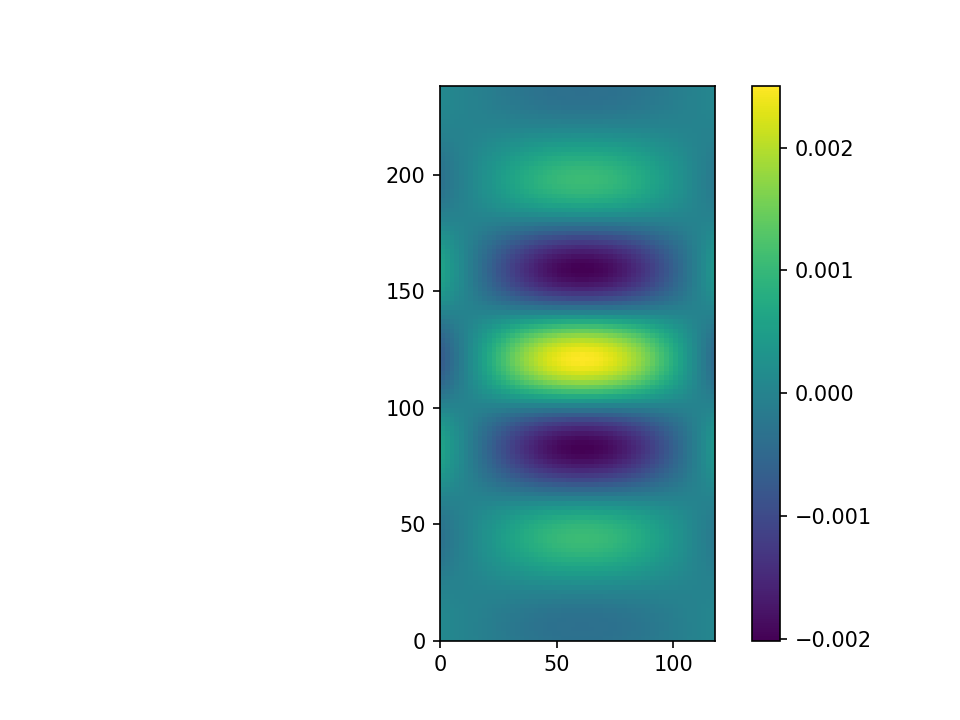

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(xin, yin, OIs.Kdd[nx*ny//2+nx//2,:].reshape((ny,nx)))
ax.set_aspect('equal')
plt.colorbar()

In [13]:
OIs.log_marg_likelihood(yd).compute()

-1915.232938969717

In [ ]:
da.random.